This program draws a "heat map" of COVID cases based on the Covid-19 dataset. The dataset includes information about
case counts over time. <br>
It relies on a pre-made country map JSON to make the Folium overlay, and a "better_names" csv which I wrote so that the
code wouldn't get too cluttered.

To Do:
Figure out why France displays as the wrong color.

Imports standard libraries:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mp
import folium as fol
import pycountry as pc
from urllib.request import urlopen
from json import load

Loads data files on GitHub (used for Colab)

In [ ]:
COVID_DATA_URL = "https://raw.githubusercontent.com/WBArno/PDA_Project/master/Dat/covid_19_data.csv"
BETTER_NAMES_URL = "https://raw.githubusercontent.com/WBArno/PDA_Project/master/Dat/better_names.csv"
COUNTRIES_URL = "https://raw.githubusercontent.com/WBArno/PDA_Project/master/Dat/countries.json"
MERGED_COUNTRIES_URL = "https://raw.githubusercontent.com/WBArno/PDA_Project/master/Dat/merged_countries.json"

# df = pd.read_csv(COVID_DATA_URL)
# bn = pd.read_csv(BETTER_NAMES_URL)
# ct = load(urlopen(COUNTRIES_URL))
# mc = load(urlopen(MERGED_COUNTRIES_URL))

Loads Data Files (used for execution locally/ GitHub).

In [ ]:
df = pd.read_csv("../Dat/covid_19_data.csv")
bn = pd.read_csv("../Dat/better_names.csv")
ct = load(open("../Dat/countries.json"))
mc = load(open("../Dat/merged_countries.json"))

Changes the poorly-named-countries into ones that PyCountry can recognize; uses better_names.csv

In [ ]:
def sanitize_csv(original, new):
    if new == "nil" or new is None:
        df["Country"] = df["Country"].str.replace(original, "", regex=True)
    else:
        df["Country"] = df["Country"].str.replace(original, new, regex=True)

# Stage 2 Tasks

In [4]:
# Project Tasks
p2 = df # Creating a new dataframe for this section

p2["Location"] = p2["Province/State"] + ", " + p2["Country/Region"]
p2 = p2.groupby(["SNo", "ObservationDate", "Location", "Confirmed", "Recovered", "Deaths"],
                as_index=False).agg({"Recovered":"sum"})
p2.set_index(["SNo"], inplace=True) # Sets the index to SNo, because why not
p2 = p2[p2.Recovered > p2.Recovered.mean()]
p2.to_csv("test_output.csv")

p2

,ObservationDate,Location,Confirmed,Deaths,Recovered
SNo,,,,,
2819,03/01/2020,"Hubei, Mainland China",66907.0,2761.0,31536.0
2944,03/02/2020,"Hubei, Mainland China",67103.0,2803.0,33934.0
3085,03/03/2020,"Hubei, Mainland China",67217.0,2835.0,36208.0
3236,03/04/2020,"Hubei, Mainland China",67332.0,2871.0,38557.0
3396,03/05/2020,"Hubei, Mainland China",67466.0,2902.0,40592.0
...,...,...,...,...,...
236006,02/27/2021,"Yaroslavl Oblast, Russia",32668.0,397.0,31016.0
236010,02/27/2021,"Zabaykalsky Krai, Russia",38523.0,528.0,36849.0
236012,02/27/2021,"Zakarpattia Oblast, Ukraine",39830.0,900.0,30516.0


# Stage 3 Tasks

## Part 1 - NaN

### 1.1 - isna()

In [5]:
p3 = df
p3.isna().sum()

SNo                    0
ObservationDate        0
Province/State     62045
Country/Region         0
Last Update            0
Confirmed              0
Deaths                 0
Recovered              0
Location           62045
dtype: int64

There are 62,045 missing values in the table; all located under the Province/State column.

### 1.3 - dropna()

Drops all of the rows with null values. <br>
Displays a count of all remaining NaN values to show

In [6]:
trunc = p3.dropna()
trunc.isna().sum().sum() # Total count of NaN values

0

### 1.2 - fillna()

Instead of dropping the null values, this replaces them with "Undefined". <br>
Prints a row with a null value before/after the modification to show the change.

In [7]:
print(p3["Province/State"][35])
p3.fillna("Undefined", inplace=True)
print(p3["Province/State"][35])
p3.isna().sum().sum() # Total count of NaN values.

nan
Undefined


0

## Part 2 - Plotting

### 2.1 - Histograms

Creates a set of histograms by sorted data:<br>
1) Confirmed Cases:

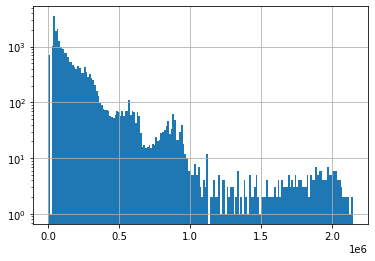

In [8]:
# Using the filtered plot from Stage 2 to reduce migraines (caused by the number of data points) slightly.
p2_state_hist = p2["Confirmed"].hist(bins="auto", log=True)

2) Recovered Cases:

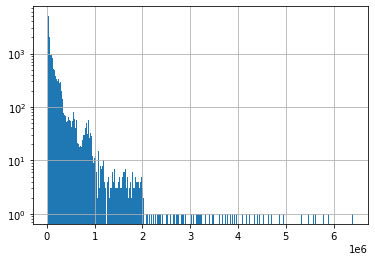

In [9]:
p2_chaos_hist = p2["Recovered"].hist(bins="auto", log=True)

3) Deaths:

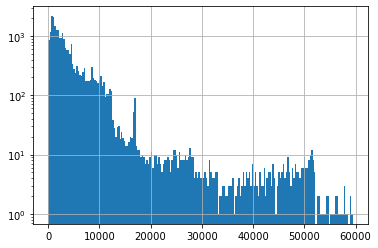

In [10]:
p2_balanced_hist = p2["Deaths"].hist(bins="auto", log=True)

### 2.2 - Plots Within Plots

All three plots, but together now!

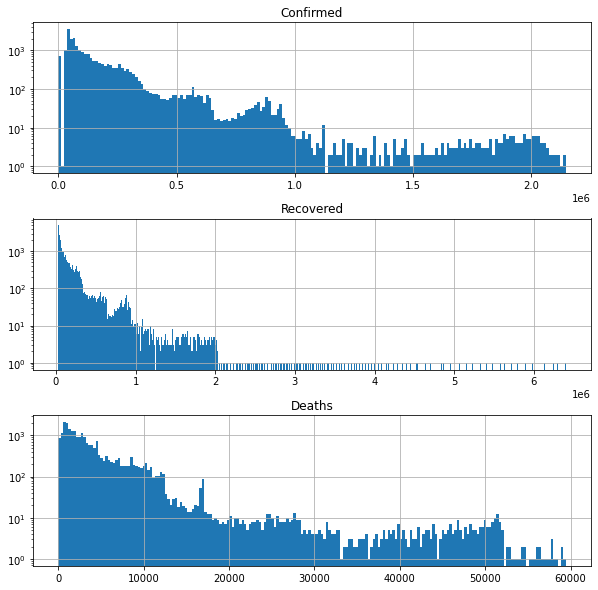

In [11]:
p2_grouped_hist = p2.hist(column=["Confirmed", "Recovered", "Deaths"],
                          bins="auto", layout=(3, 1), figsize=(10, 10), log=True)

### 2.3 - Single-Line Graph

This is an attempt at graphing recovered cases over time. <br>
*It turns out that 20,000 data points don't make for a good line graph.*

<AxesSubplot:xlabel='ObservationDate'>

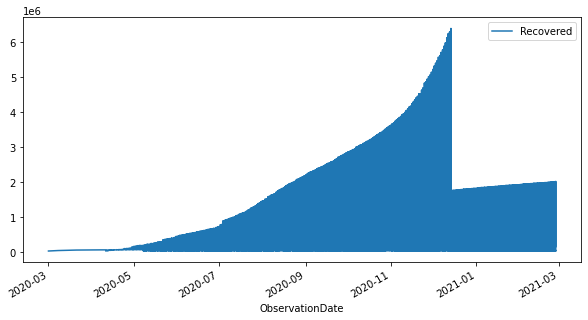

In [12]:
p2["ObservationDate"] = pd.to_datetime(p2["ObservationDate"])
p2.sort_values(by="ObservationDate", ascending=True, inplace=True)
p2.plot(x="ObservationDate", y="Recovered", figsize=(10,5))

### 2.4 - Multi-Line Graph

Now with less data points!

Text(0.5, 100, '|----------?----------|')

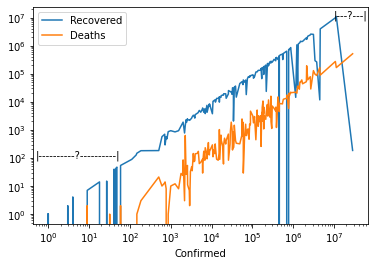

In [13]:
def aggravate(tmp_series, target):
    return tmp_series.aggregate({target:"last"}).groupby(["Country/Region"], as_index=False,
                                                         dropna=False).aggregate({target:"sum"})[target]


tmp_ser = df.groupby(["Country/Region", "Province/State"], as_index=False, dropna=False)#.aggregate({"Confirmed":"last"})

lg = pd.DataFrame()
lg["Country"] = (tmp_ser.aggregate({"Confirmed":"last"}).groupby(["Country/Region"], as_index=False,dropna=False).
                 aggregate({"Confirmed":"sum"}))["Country/Region"]
lg["Confirmed"] = aggravate(tmp_ser, "Confirmed")
lg["Recovered"] = aggravate(tmp_ser, "Recovered")
lg["Deaths"] = aggravate(tmp_ser, "Deaths")
lg.sort_values(by="Confirmed", ascending=True, inplace=True)


lg.plot('Confirmed', legend=True, logx=True, logy=True)
mp.pyplot.annotate('|---?---|', (10**7, 10**7))
mp.pyplot.annotate('|----------?----------|', (0.5, 100))

### 2.4 - Multi-Line Graph

Now with beautiful labels!

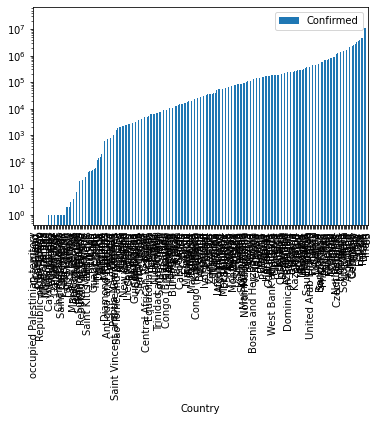

In [14]:
lg_bar = lg
lg_bar.set_index("Country")
lg_bar.plot.bar("Country", "Confirmed", logy=True)

mp.pyplot.savefig("modern_art.png")

# -- Run --

Prepares the table for use by dropping unneeded columns and renaming an annoying one.

In [15]:
df.drop(["SNo", "ObservationDate", "Recovered", "Last Update", "Deaths"], axis=1, inplace=True)
df.rename(columns = {"Country/Region": "Country"}, inplace=True)

"Sanitizes" the country names so that PyCountry will recognize them, then collapses them all together.

In [16]:
for row in bn.itertuples(): sanitize_csv(row[1], row[2])

Groups by and finds the maximum value for each state (the entries are cumulative, so a single group would result in an
absurd amount of cases.)

In [ ]:
df = df.groupby(["Country", "Province/State"], as_index=False, dropna=False).aggregate({"Confirmed":"last"})

Groups the table again by country, finding the sum of all of the states.

In [ ]:
df = df.groupby(["Country"], as_index=False, dropna=False).aggregate({"Confirmed":"sum"})

Uses PyCountry to find the three-letter acronym for each country for use with Folium.

In [17]:
for row in df["Country"]: df["Country"] = df["Country"].replace(row, pc.countries.search_fuzzy(row)[0].alpha_3)


Takes the log of all values in order to make a more meaningful map. <br>
Without this step, only three countries would be colored anything other than yellow.

In [18]:
for row in df["Confirmed"]: df["Confirmed"] = df["Confirmed"].replace(row, np.log(row))
df.dropna(inplace=True) # Necessary to remove broken entries created by the above process.

<ipython-input-18-43e808d261fd>:1: RuntimeWarning: divide by zero encountered in log
  for row in df["Confirmed"]: df["Confirmed"] = df["Confirmed"].replace(row, np.log(row))
<ipython-input-18-43e808d261fd>:1: RuntimeWarning: invalid value encountered in log
  for row in df["Confirmed"]: df["Confirmed"] = df["Confirmed"].replace(row, np.log(row))


Creates the Folium map.

In [19]:
outbreak_map = fol.Map(location=[0, 0], zoom_start=0)

fol.Choropleth(
    name = "COVID Cases",
    geo_data = ct, # Polygonal data to draw the country map.
    data = df, # COVID case data
    columns = ["Country", "Confirmed"], # Column to match with the key, count-based column.
    key_on = "feature.id", # Establishes the key of the country JSON.
    fill_color = "YlOrRd", # Color scheme
    fill_opacity = 0.75,
    line_opacity = 0.25,
    nan_fill_opacity = 0,
    legend_name = "Confirmed Cases",
    highlight = True,
).add_to(outbreak_map)

Creates an overlay for the above folium map which displays the confirmed count.

In [20]:
OverlayData = fol.features.GeoJson(
    mc,
    style_function = lambda x: {'fillColor': '#ffffff', 'color':'#000000', 'fillOpacity': 0.2, 'weight': 0.2},
    highlight_function = lambda x: {'fillColor': '#000000', 'color':'#000000', 'fillOpacity': 0.50, 'weight': 0.1},
    control = False,
    tooltip = fol.features.GeoJsonTooltip(
        fields = ["name", "Confirmed"],
        aliases = ["Country: ", "Confirmed Cases: "],
        style = "background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"
    )
)

outbreak_map.add_child(OverlayData)
outbreak_map.keep_in_front(OverlayData)
fol.LayerControl().add_to(outbreak_map)

In [21]:
# Displays the map
outbreak_map